In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1️⃣ Data Collection: OOF & Public LB Scores

각 CV 전략별로 점수를 기록합니다.

In [4]:
# CV 전략별 결과 기록 (각 전략당 5개 submission)
cv_results = pd.DataFrame({
    'cv_strategy': [
        # time_based (5 submissions)
        'time_based_v1',
        'time_based_v2',
        'time_based_v3',
        # expanding_window (5 submissions)
        'expanding_window_v1',
        'expanding_window_v2',
        'expanding_window_v3',
        # purged_walk_forward (5 submissions)
        'purged_walk_forward_v1',
        'purged_walk_forward_v2',
        'purged_walk_forward_v3',
        # regime_aware (5 submissions)
        'regime_aware_v1',
        'regime_aware_v2',
        'regime_aware_v3',
    ],
    'strategy_type': [
        # time_based
        'time_based', 'time_based', 'time_based',
        # expanding_window
        'expanding_window', 'expanding_window', 'expanding_window',
        # purged_walk_forward
        'purged_walk_forward', 'purged_walk_forward', 'purged_walk_forward',
        # regime_aware
        'regime_aware', 'regime_aware', 'regime_aware',
    ],
    'version': [1, 2, 3] * 4,  # 각 전략당 버전 1~5
    'oof_score': [
        # time_based
        8.520537, 8.157893, 8.518761,
        # expanding_window
        7.520666, 7.249472, 6.829987,
        # purged_walk_forward
        8.782901, 8.82709, 8.82098,
        # regime_aware
        8.551479, 8.275325, 8.332089
    ],
    'public_lb': [
        0.366, 0.455, 0.456,
        # expanding_window
        0.417, 0.457, 0.454,
        # purged_walk_forward
        0.376, 0.400, 0.455,
        # regime_aware
        0.461, 0.451, 0.442
    ],
    'notes': [
        # time_based
        'Baseline with ensemble fix', 'Tuned hyperparameters', 'Feature Engineering', 
        # expanding_window
        '', '', '',
        # purged_walk_forward
        '', '', '',
        # regime_aware
        '', '', '',
    ]
})

print("📊 Current Status:")
print(cv_results.to_string(index=False))
print(f"\n✅ Completed: {cv_results['oof_score'].notna().sum()}/12")
print(f"⏳ Pending OOF: {cv_results['oof_score'].isna().sum()}/12")
print(f"⏳ Pending LB: {cv_results['public_lb'].isna().sum()}/12")

# 전략별 요약
print("\n📈 By Strategy Type:")
for strategy in ['time_based', 'expanding_window', 'purged_walk_forward', 'regime_aware']:
    mask = cv_results['strategy_type'] == strategy
    completed = cv_results[mask]['oof_score'].notna().sum()
    print(f"  {strategy:20s}: {completed}/3 completed")

📊 Current Status:
           cv_strategy       strategy_type  version  oof_score  public_lb                      notes
         time_based_v1          time_based        1   8.520537      0.366 Baseline with ensemble fix
         time_based_v2          time_based        2   8.157893      0.455      Tuned hyperparameters
         time_based_v3          time_based        3   8.518761      0.456        Feature Engineering
   expanding_window_v1    expanding_window        1   7.520666      0.417                           
   expanding_window_v2    expanding_window        2   7.249472      0.457                           
   expanding_window_v3    expanding_window        3   6.829987      0.454                           
purged_walk_forward_v1 purged_walk_forward        1   8.782901      0.376                           
purged_walk_forward_v2 purged_walk_forward        2   8.827090      0.400                           
purged_walk_forward_v3 purged_walk_forward        3   8.820980      0.455

## 2️⃣ Correlation Analysis

OOF Score와 Public LB의 상관관계를 분석합니다

In [6]:
def analyze_cv_reliability(df):
    """
    CV와 Public LB의 신뢰도 분석
    
    Returns:
        dict: 상관관계, 스케일 비율, 신뢰도 등급
    """
    # NaN 제거
    valid_df = df.dropna(subset=['oof_score', 'public_lb'])
    
    if len(valid_df) < 2:
        print("⚠️  Not enough data for analysis (need at least 2 complete entries)")
        return None
    
    oof = valid_df['oof_score'].values
    lb = valid_df['public_lb'].values
    
    # 1. Pearson Correlation (선형 상관관계)
    pearson_corr, pearson_p = pearsonr(oof, lb)
    
    # 2. Spearman Correlation (순위 상관관계)
    spearman_corr, spearman_p = spearmanr(oof, lb)
    
    # 3. Mean Absolute Error
    mae = np.mean(np.abs(oof - lb))
    
    # 4. Scale Ratio (스케일 차이)
    scale_ratio = oof.mean() / lb.mean()
    
    # 5. Directional Consistency (순위 일치도)
    oof_ranks = valid_df['oof_score'].rank(ascending=False)
    lb_ranks = valid_df['public_lb'].rank(ascending=False)
    rank_match = (oof_ranks == lb_ranks).mean()
    
    # 6. Best Strategy Consistency (전략 타입별)
    best_by_strategy = {}
    for strategy_type in valid_df['strategy_type'].unique():
        s_mask = valid_df['strategy_type'] == strategy_type
        s_df = valid_df[s_mask]
        if len(s_df) > 0:
            best_oof = s_df['oof_score'].max()
            best_lb = s_df['public_lb'].max()
            best_by_strategy[strategy_type] = {
                'best_oof': best_oof,
                'best_lb': best_lb,
                'oof_lb_diff': abs(best_oof - best_lb)
            }
    
    # 신뢰도 등급 판정
    if spearman_corr > 0.8:
        reliability = "HIGH ✅"
        recommendation = "Trust OOF ranking. Use best CV strategy."
    elif spearman_corr > 0.5:
        reliability = "MEDIUM ⚠️"
        recommendation = "Consider ensemble of top versions from best strategy."
    else:
        reliability = "LOW ❌"
        recommendation = "CV unreliable. Need feature engineering or domain adaptation."
    
    results = {
        'pearson_correlation': pearson_corr,
        'pearson_pvalue': pearson_p,
        'spearman_correlation': spearman_corr,
        'spearman_pvalue': spearman_p,
        'mae': mae,
        'scale_ratio': scale_ratio,
        'rank_match_rate': rank_match,
        'best_by_strategy': best_by_strategy,
        'reliability': reliability,
        'recommendation': recommendation,
        'n_samples': len(valid_df)
    }
    
    return results

# 분석 실행 (데이터가 충분할 때)
reliability = analyze_cv_reliability(cv_results)

if reliability:
    print("\n" + "="*80)
    print("📊 CV RELIABILITY ANALYSIS")
    print("="*80)
    print(f"Samples analyzed: {reliability['n_samples']}/12\n")
    
    print(f"Pearson Correlation:  {reliability['pearson_correlation']:.4f} (p={reliability['pearson_pvalue']:.4f})")
    print(f"Spearman Correlation: {reliability['spearman_correlation']:.4f} (p={reliability['spearman_pvalue']:.4f})")
    print(f"MAE (OOF - LB):       {reliability['mae']:.4f}")
    print(f"Scale Ratio:          {reliability['scale_ratio']:.4f}x")
    print(f"Rank Match Rate:      {reliability['rank_match_rate']:.1%}\n")
    
    print("📈 Best by Strategy Type:")
    for strategy, metrics in reliability['best_by_strategy'].items():
        print(f"  {strategy:20s}: OOF={metrics['best_oof']:.4f}, LB={metrics['best_lb']:.4f}, diff={metrics['oof_lb_diff']:.4f}")
    
    print(f"\nReliability Grade: {reliability['reliability']}")
    print(f"Recommendation: {reliability['recommendation']}")
    print("="*80)


📊 CV RELIABILITY ANALYSIS
Samples analyzed: 12/12

Pearson Correlation:  -0.3408 (p=0.2783)
Spearman Correlation: -0.2557 (p=0.4225)
MAE (OOF - LB):       7.7664
Scale Ratio:          18.9571x
Rank Match Rate:      0.0%

📈 Best by Strategy Type:
  time_based          : OOF=8.5205, LB=0.4560, diff=8.0645
  expanding_window    : OOF=7.5207, LB=0.4570, diff=7.0637
  purged_walk_forward : OOF=8.8271, LB=0.4550, diff=8.3721
  regime_aware        : OOF=8.5515, LB=0.4610, diff=8.0905

Reliability Grade: LOW ❌
Recommendation: CV unreliable. Need feature engineering or domain adaptation.


## 3️⃣ Visualization

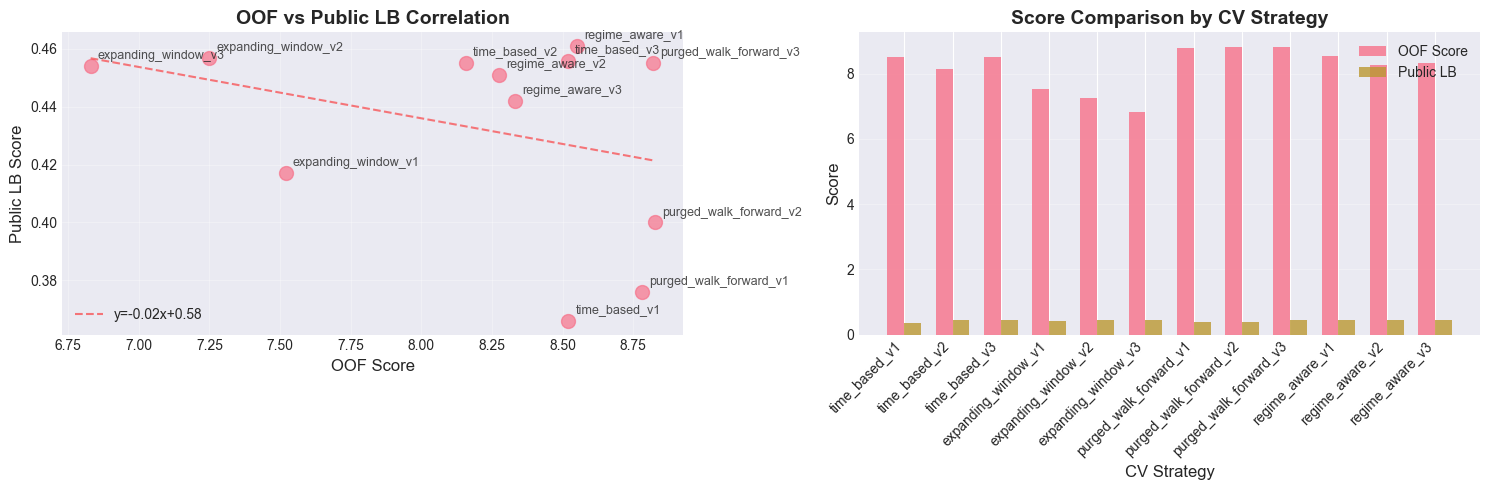

In [7]:
def plot_cv_lb_correlation(df):
    """
    OOF vs Public LB 산점도 및 상관관계 시각화
    """
    valid_df = df.dropna(subset=['oof_score', 'public_lb'])
    
    if len(valid_df) < 2:
        print("⚠️  Not enough data for visualization")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Scatter plot with regression line
    ax1 = axes[0]
    ax1.scatter(valid_df['oof_score'], valid_df['public_lb'], s=100, alpha=0.7)
    
    # 전략 이름 표시
    for idx, row in valid_df.iterrows():
        ax1.annotate(row['cv_strategy'], 
                    (row['oof_score'], row['public_lb']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    # Regression line
    z = np.polyfit(valid_df['oof_score'], valid_df['public_lb'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid_df['oof_score'].min(), valid_df['oof_score'].max(), 100)
    ax1.plot(x_line, p(x_line), "r--", alpha=0.5, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
    
    ax1.set_xlabel('OOF Score', fontsize=12)
    ax1.set_ylabel('Public LB Score', fontsize=12)
    ax1.set_title('OOF vs Public LB Correlation', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Bar chart comparison
    ax2 = axes[1]
    x = np.arange(len(valid_df))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, valid_df['oof_score'], width, label='OOF Score', alpha=0.8)
    bars2 = ax2.bar(x + width/2, valid_df['public_lb'], width, label='Public LB', alpha=0.8)
    
    ax2.set_xlabel('CV Strategy', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('Score Comparison by CV Strategy', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(valid_df['cv_strategy'], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# 시각화 실행
plot_cv_lb_correlation(cv_results)

## 4️⃣ OOF to LB Calibration

OOF 점수를 Public LB 스케일로 변환하는 함수

In [8]:
def calibrate_oof_to_lb(oof_score, scale_ratio, offset=0):
    """
    OOF 점수를 Public LB 스케일로 변환
    
    Parameters:
        oof_score: OOF validation score
        scale_ratio: oof.mean() / lb.mean()
        offset: 추가 보정값 (선형 회귀에서 계산)
    
    Returns:
        float: 예측된 Public LB score
    """
    return oof_score / scale_ratio + offset

# 예시: 새로운 OOF 점수의 LB 예측
if reliability and reliability['n_samples'] >= 2:
    new_oof = 9.0  # 예시 OOF 점수
    predicted_lb = calibrate_oof_to_lb(new_oof, reliability['scale_ratio'])
    
    print(f"\n📈 Calibration Example:")
    print(f"If OOF Score = {new_oof:.2f}")
    print(f"Predicted Public LB ≈ {predicted_lb:.4f}")
    print(f"(using scale_ratio = {reliability['scale_ratio']:.4f})")


📈 Calibration Example:
If OOF Score = 9.00
Predicted Public LB ≈ 0.4748
(using scale_ratio = 18.9571)


## 5️⃣ Decision Framework

최종 CV 전략 선택 및 다음 단계 결정

In [9]:
def recommend_final_strategy(df, reliability_results):
    """
    최종 CV 전략 추천
    """
    valid_df = df.dropna(subset=['oof_score', 'public_lb'])
    
    if len(valid_df) < 2:
        print("⚠️  Need more data for recommendation")
        return
    
    print("\n" + "="*80)
    print("🎯 FINAL STRATEGY RECOMMENDATION")
    print("="*80)
    
    # 순위 계산
    valid_df['oof_rank'] = valid_df['oof_score'].rank(ascending=False)
    valid_df['lb_rank'] = valid_df['public_lb'].rank(ascending=False)
    valid_df['avg_rank'] = (valid_df['oof_rank'] + valid_df['lb_rank']) / 2
    
    # 정렬
    ranked = valid_df.sort_values('avg_rank')
    
    print("\n📊 Strategy Ranking:")
    print(ranked[['cv_strategy', 'oof_score', 'public_lb', 'oof_rank', 'lb_rank', 'avg_rank']].to_string(index=False))
    
    best_strategy = ranked.iloc[0]['cv_strategy']
    
    print(f"\n🏆 Best Strategy: {best_strategy}")
    print(f"   OOF Score: {ranked.iloc[0]['oof_score']:.4f}")
    print(f"   Public LB: {ranked.iloc[0]['public_lb']:.4f}")
    
    # 신뢰도에 따른 추가 조언
    if reliability_results:
        print(f"\n💡 Based on {reliability_results['reliability']} reliability:")
        print(f"   {reliability_results['recommendation']}")
        
        if reliability_results['spearman_correlation'] < 0.5:
            print("\n⚠️  WARNING: Low CV-LB correlation detected!")
            print("   Consider:")
            print("   1. Feature engineering to reduce distribution shift")
            print("   2. Domain adaptation techniques")
            print("   3. Ensemble of multiple CV strategies")
            print("   4. Public LB probing (if allowed)")
    
    print("="*80)

# 추천 실행
if reliability:
    recommend_final_strategy(cv_results, reliability)


🎯 FINAL STRATEGY RECOMMENDATION

📊 Strategy Ranking:
           cv_strategy  oof_score  public_lb  oof_rank  lb_rank  avg_rank
       regime_aware_v1   8.551479      0.461       4.0      1.0      2.50
purged_walk_forward_v3   8.820980      0.455       2.0      4.5      3.25
         time_based_v3   8.518761      0.456       6.0      3.0      4.50
purged_walk_forward_v2   8.827090      0.400       1.0     10.0      5.50
   expanding_window_v2   7.249472      0.457      11.0      2.0      6.50
         time_based_v2   8.157893      0.455       9.0      4.5      6.75
purged_walk_forward_v1   8.782901      0.376       3.0     11.0      7.00
       regime_aware_v2   8.275325      0.451       8.0      7.0      7.50
       regime_aware_v3   8.332089      0.442       7.0      8.0      7.50
         time_based_v1   8.520537      0.366       5.0     12.0      8.50
   expanding_window_v3   6.829987      0.454      12.0      6.0      9.00
   expanding_window_v1   7.520666      0.417      10.0    

## 6️⃣ Update Results

새로운 결과를 기록할 때 사용하는 헬퍼 함수

In [10]:
def update_result(strategy_name, oof_score=None, public_lb=None, notes=''):
    """
    결과 업데이트
    
    Example:
        update_result('time_based_v1', oof_score=8.52, public_lb=0.87)
        update_result('expanding_window_v2', oof_score=9.12)
    """
    global cv_results
    
    mask = cv_results['cv_strategy'] == strategy_name
    
    if mask.sum() == 0:
        print(f"❌ Strategy '{strategy_name}' not found!")
        print("Available strategies:")
        for s in cv_results['cv_strategy'].unique():
            print(f"  - {s}")
        return
    
    if oof_score is not None:
        cv_results.loc[mask, 'oof_score'] = oof_score
        print(f"✅ Updated OOF score for {strategy_name}: {oof_score:.6f}")
    
    if public_lb is not None:
        cv_results.loc[mask, 'public_lb'] = public_lb
        cv_results.loc[mask, 'submission_date'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')
        print(f"✅ Updated Public LB for {strategy_name}: {public_lb:.6f}")
    
    if notes:
        cv_results.loc[mask, 'notes'] = notes
    
    print("\n📊 Updated Results:")
    print(cv_results.to_string(index=False))
    
    # 전략별 요약
    print("\n📈 Progress by Strategy Type:")
    for strategy in ['time_based', 'expanding_window', 'purged_walk_forward', 'regime_aware']:
        s_mask = cv_results['strategy_type'] == strategy
        oof_completed = cv_results[s_mask]['oof_score'].notna().sum()
        lb_completed = cv_results[s_mask]['public_lb'].notna().sum()
        print(f"  {strategy:20s}: OOF {oof_completed}/5, LB {lb_completed}/5")
    
    # CSV 저장
    cv_results.to_csv('../results/cv_reliability_tracking.csv', index=False)
    print("\n💾 Saved to results/cv_reliability_tracking.csv")

# 사용 예시:
# update_result('time_based_v1', public_lb=0.87, notes='Fixed ensemble bug')
# update_result('time_based_v2', oof_score=8.65, notes='Tuned hyperparameters')

## 📝 Notes & Observations

중요한 발견사항을 여기에 기록하세요:

### 2025-01-21
- time_based OOF = 8.52
- Ensemble prediction bug fixed (was averaging predictions instead of ensembling)
- Waiting for Public LB results...

### TODO
- [ ] Train expanding_window CV
- [ ] Train purged_walk_forward CV
- [ ] Train regime_aware CV
- [ ] Submit all 4 models to Kaggle
- [ ] Analyze correlation
- [ ] Choose final strategy